In [1]:
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plot_fairness_metrics import *

pip install 'aif360[inFairness]'


In [2]:
def compute_individual_weights(df, label_col, protected_attr_col):
    """
    Compute weights for a single protected attribute to rebalance joint label/protected group distribution.
    """
    joint_counts = df.groupby([protected_attr_col, label_col]).size().reset_index(name='joint_count')
    attr_counts = df[protected_attr_col].value_counts(normalize=True).reset_index()
    attr_counts.columns = [protected_attr_col, 'attr_prob']
    label_counts = df[label_col].value_counts(normalize=True).reset_index()
    label_counts.columns = [label_col, 'label_prob']

    weights_df = joint_counts.merge(attr_counts, on=protected_attr_col)
    weights_df = weights_df.merge(label_counts, on=label_col)

    weights_df['weight'] = weights_df['attr_prob'] * weights_df['label_prob'] / (weights_df['joint_count'] / len(df))

    return weights_df[[protected_attr_col, label_col, 'weight']]

def compute_combined_weights(df, label_col, protected_attrs):
    """
    Compute instance weights by multiplying individual fairness weights across multiple protected attributes.
    """
    df = df.copy()
    df['weight'] = 1.0  # Start with neutral weights

    for attr in protected_attrs:
        w = compute_individual_weights(df, label_col, attr)
        w = w.rename(columns={'weight': f'weight_{attr}'})
        df = df.merge(w, on=[attr, label_col], how='left')
        df['weight'] *= df[f'weight_{attr}']

    return df


In [3]:
from sklearn.preprocessing import QuantileTransformer

def remove_disparate_impact_global(df, features, protected_attr, repair_level=0.5):
    df = df.copy()
    
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan

        # Global reference distribution
        qt_global = QuantileTransformer(output_distribution='normal')
        global_transformed = qt_global.fit_transform(df[[feature]]).flatten()

        df[f"{feature}_quantile"] = global_transformed  # for interpolation

        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            original = df.loc[group_mask, feature]
            transformed = df.loc[group_mask, f"{feature}_quantile"]
            repaired = (1 - repair_level) * original + repair_level * transformed
            df.loc[group_mask, repaired_col] = repaired

        df.drop(columns=[f"{feature}_quantile"], inplace=True)

    return df


In [4]:
from sklearn.preprocessing import QuantileTransformer
import pandas as pd
import numpy as np

def remove_disparate_impact(df, features, protected_attr, repair_level=1.0):

    df = df.copy()
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan
        
        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            group_values = df.loc[group_mask, feature].values.reshape(-1, 1)
            
            qt = QuantileTransformer(output_distribution='normal')
            transformed = qt.fit_transform(group_values).flatten()
            
            original = df.loc[group_mask, feature]
            repaired = (1 - repair_level) * original + repair_level * transformed
            
            df.loc[group_mask, repaired_col] = repaired

    return df


In [5]:
df = pd.read_csv('complete_df_with_predictions.csv')
df_copied = df.copy()
predicted_cols = ['pass_bar_lr', 'pass_bar_lr_weighted',
       'pass_bar_lr_best', 'pass_bar_rf', 'pass_bar_xgb', 'pass_bar_xgb_r']
df.drop(columns=predicted_cols, inplace=True)

In [6]:
race_enc = LabelEncoder()
df['race1_encoded'] = race_enc.fit_transform(df['race1'])

In [7]:
race_mapping = dict(zip(race_enc.classes_, race_enc.transform(race_enc.classes_)))
print(race_mapping)

{'asian': 0, 'black': 1, 'hisp': 2, 'other': 3, 'white': 4}


In [8]:
nokeep = ['bar', 'race2', 'race1']
keep = list(set(df.columns) - set(nokeep))
df = df[keep]

In [9]:
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'race1_encoded']

target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [10]:
df_train = X_train.copy()
df_train[target] = y_train
df_test = X_test.copy()
df_test[target] = y_test

In [11]:
new_features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'race1_encoded_repaired', 'tier_repaired', 'fam_inc_repaired']

In [12]:
df_train_rw = df_train.copy()
df_train_rw['race1_encoded_repaired'] = remove_disparate_impact(df_train, ['race1_encoded'], 'race1_encoded')['race1_encoded_repaired']
df_train_rw['tier_repaired'] = remove_disparate_impact(df_train, ['tier'], 'tier')['tier_repaired']
df_train_rw['fam_inc_repaired'] = remove_disparate_impact(df_train, ['fam_inc'], 'fam_inc')['fam_inc_repaired']

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (814). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (711). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (324). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (475). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local

In [13]:
protected_features = ['race1_encoded', 'tier', 'fam_inc']
df_train_rw = compute_combined_weights(df_train_rw, label_col='pass_bar', protected_attrs=protected_features)

In [14]:
X_train_rw = df_train_rw[new_features]
y_train_rw = df_train_rw[target]

In [15]:
from xgboost import XGBClassifier
import numpy as np

ratio = np.sum(y_train_rw == 0) / np.sum(y_train_rw == 1)

xgb_best_model_regul_3 = XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=ratio, reg_alpha=5, reg_lambda=5, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200)  
xgb_best_model_regul_3.fit(X_train_rw, y_train_rw)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [16]:
# from sklearn.metrics import confusion_matrix, classification_report


# y_test_pred = lr_best_model.predict(X_test)

# print(confusion_matrix(y_test, y_test_pred))
# print(classification_report(y_test, y_test_pred))

### on whole dataset

In [17]:
df_rw = df.copy()
df_rw['race1_encoded_repaired'] = remove_disparate_impact_global(df, ['race1_encoded'], 'race1_encoded')['race1_encoded_repaired']
df_rw['tier_repaired'] = remove_disparate_impact_global(df, features=['tier'], protected_attr='tier', repair_level=1.0)['tier_repaired']
df_rw['fam_inc_repaired'] = remove_disparate_impact_global(df, features=['fam_inc'], protected_attr='fam_inc', repair_level=1.0)['fam_inc_repaired']

In [18]:
df_rw

,race1_white,bar1_yr,grad,fam_inc,zfygpa,race1_hisp,parttime,academic_career,bar1,bar2_yr,...,decile3,race1_other,pass_bar,bar2,Unnamed: 0,tier,race,race1_encoded_repaired,tier_repaired,fam_inc_repaired
0,True,7.0,1,5.0,1.33,False,0.0,1.341087,1,94.0,...,10.0,False,1,1,0,4.0,7.0,4.599669,0.249721,5.199338
1,True,7.0,1,4.0,-0.11,False,0.0,-0.385252,1,94.0,...,4.0,False,1,1,1,2.0,7.0,4.599669,-1.505747,0.533636
2,True,7.0,1,1.0,-0.64,False,0.0,-0.355093,1,94.0,...,2.0,False,1,1,2,3.0,7.0,4.599669,-0.574595,-5.199338
3,True,7.0,1,4.0,0.34,False,0.0,0.217453,1,94.0,...,4.0,False,1,1,3,3.0,7.0,4.599669,-0.574595,0.533636
4,True,7.0,1,4.0,1.02,False,0.0,1.144843,1,94.0,...,8.0,False,1,1,4,5.0,7.0,4.599669,0.924252,0.533636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,False,2.0,1,2.0,-0.58,False,0.0,-1.922560,0,95.0,...,1.0,False,0,0,22402,1.0,3.0,-0.228448,-5.199338,-1.467860
22068,False,7.0,1,3.0,-0.64,False,0.0,-2.216261,0,94.0,...,1.0,False,0,0,22403,1.0,3.0,-0.228448,-5.199338,-0.516356
22069,False,7.0,1,3.0,0.41,False,1.0,-0.613914,1,95.0,...,8.0,False,1,1,22404,3.0,3.0,-0.228448,-0.574595,-0.516356
22070,True,7.0,1,3.0,1.88,False,1.0,0.134185,1,95.0,...,10.0,False,1,1,22405,3.0,7.0,4.599669,-0.574595,-0.516356


In [19]:
pass_bar_xgb_dir = xgb_best_model_regul_3.predict(df_rw[new_features])
df_rw['pass_bar_xgb_dir'] = pass_bar_xgb_dir

In [20]:
df_rw

,race1_white,bar1_yr,grad,fam_inc,zfygpa,race1_hisp,parttime,academic_career,bar1,bar2_yr,...,race1_other,pass_bar,bar2,Unnamed: 0,tier,race,race1_encoded_repaired,tier_repaired,fam_inc_repaired,pass_bar_xgb_dir
0,True,7.0,1,5.0,1.33,False,0.0,1.341087,1,94.0,...,False,1,1,0,4.0,7.0,4.599669,0.249721,5.199338,1
1,True,7.0,1,4.0,-0.11,False,0.0,-0.385252,1,94.0,...,False,1,1,1,2.0,7.0,4.599669,-1.505747,0.533636,0
2,True,7.0,1,1.0,-0.64,False,0.0,-0.355093,1,94.0,...,False,1,1,2,3.0,7.0,4.599669,-0.574595,-5.199338,0
3,True,7.0,1,4.0,0.34,False,0.0,0.217453,1,94.0,...,False,1,1,3,3.0,7.0,4.599669,-0.574595,0.533636,1
4,True,7.0,1,4.0,1.02,False,0.0,1.144843,1,94.0,...,False,1,1,4,5.0,7.0,4.599669,0.924252,0.533636,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,False,2.0,1,2.0,-0.58,False,0.0,-1.922560,0,95.0,...,False,0,0,22402,1.0,3.0,-0.228448,-5.199338,-1.467860,0
22068,False,7.0,1,3.0,-0.64,False,0.0,-2.216261,0,94.0,...,False,0,0,22403,1.0,3.0,-0.228448,-5.199338,-0.516356,0
22069,False,7.0,1,3.0,0.41,False,1.0,-0.613914,1,95.0,...,False,1,1,22404,3.0,3.0,-0.228448,-0.574595,-0.516356,1
22070,True,7.0,1,3.0,1.88,False,1.0,0.134185,1,95.0,...,False,1,1,22405,3.0,7.0,4.599669,-0.574595,-0.516356,1


In [21]:
print(df_rw['race1_encoded_repaired'].describe())
print(df_rw['race1_encoded_repaired'].nunique())
print(df_rw['race1_encoded_repaired'].value_counts())

count    22072.000000
mean         3.767182
std          1.951121
min         -2.599669
25%          4.599669
50%          4.599669
75%          4.599669
max          4.599669
Name: race1_encoded_repaired, dtype: float64
5
race1_encoded_repaired
 4.599669    18462
-0.228448     1308
 0.428758     1010
-2.599669      888
 1.001040      404
Name: count, dtype: int64


In [22]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd

def compute_disparate_impact_by_race(df, label_col='pass_bar', race_col='race1_encoded', white_label=4):
    results = []

    # Filter all unique race codes except White (reference group)
    race_codes = sorted(df[race_col].unique())
    other_races = [r for r in race_codes if r != white_label]

    for group in other_races:
        # Create dataset with only White and one comparison group
        df_pair = df[df[race_col].isin([white_label, group])].copy()
        df_pair[race_col + '_bin'] = df_pair[race_col].apply(lambda x: 1 if x == white_label else 0)

        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df_pair,
            label_names=[label_col],
            protected_attribute_names=[race_col + '_bin']
        )

        metric = BinaryLabelDatasetMetric(
            dataset,
            privileged_groups=[{race_col + '_bin': 1}],  # White
            unprivileged_groups=[{race_col + '_bin': 0}]  # Current group
        )

        di = metric.disparate_impact()

        results.append({
            'Group': f'{group} vs White',
            'Disparate Impact': di
        })

    return pd.DataFrame(results)

di_results = compute_disparate_impact_by_race(df_rw, label_col='pass_bar_xgb_dir', race_col='race1_encoded', white_label=4)
print(di_results)

        Group  Disparate Impact
0  0 vs White          0.751989
1  1 vs White          0.226688
2  2 vs White          0.562475
3  3 vs White          0.712345


In [23]:
results_all = {}

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

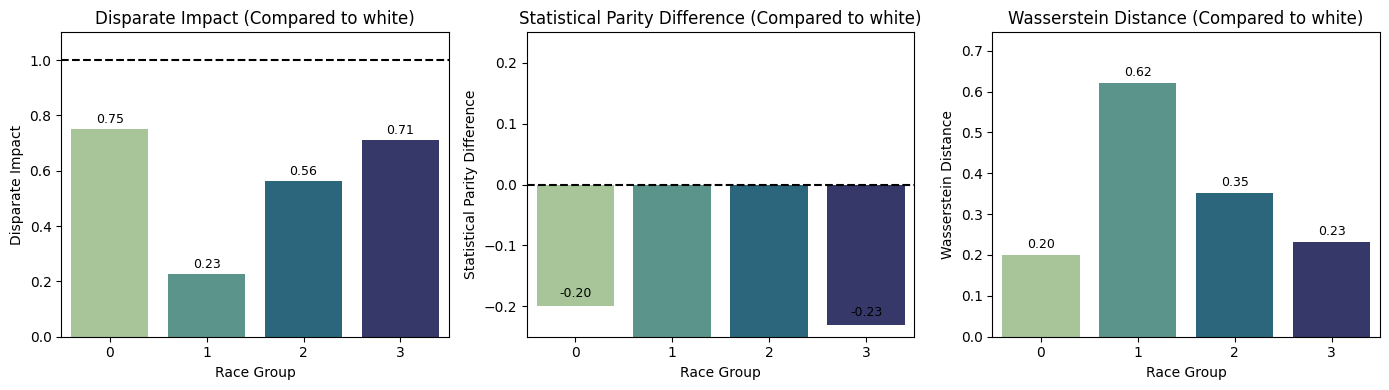

In [24]:
race_groups = [0, 1, 2, 3]
results = get_DI_SPD_WD(race_groups, df_rw, 'race1_encoded', 4, 'pass_bar_xgb_dir')
plot_fairness_metrics(results, 'Race Group', 'white')
results_all['Race'] = results

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

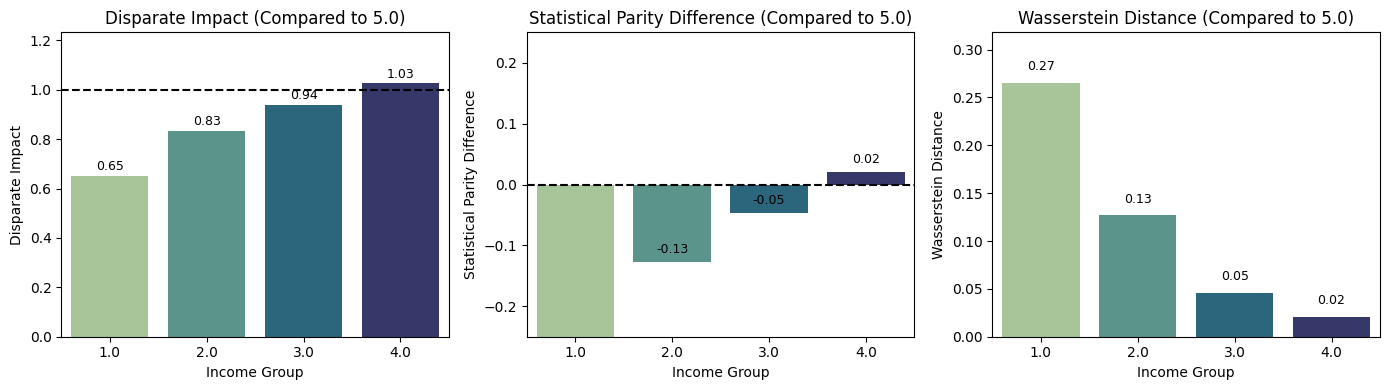

In [25]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df_rw, 'fam_inc', 5.0, 'pass_bar_xgb_dir')
plot_fairness_metrics(results, 'Income Group', 5.0)
results_all['Family Income'] = results

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

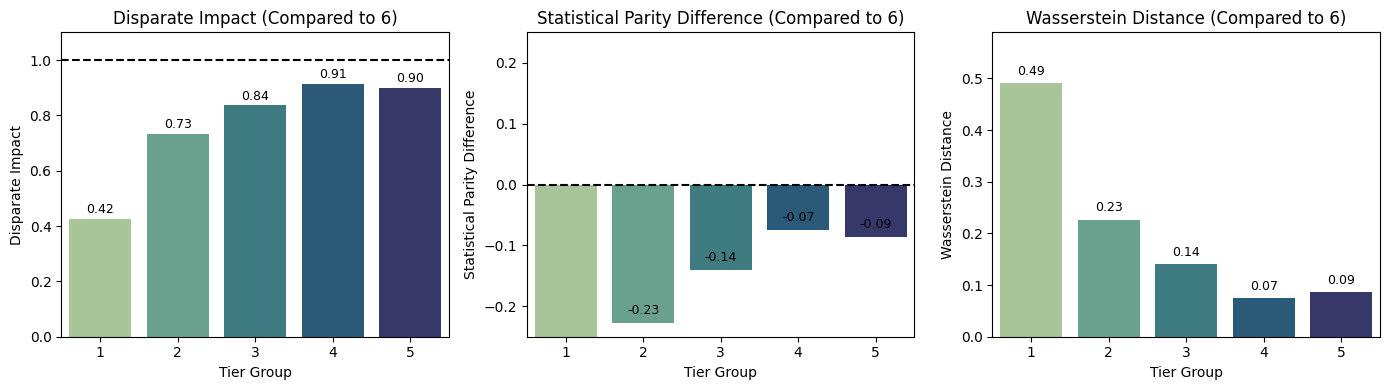

In [26]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df_rw, 'tier', 6, 'pass_bar_xgb_dir')
plot_fairness_metrics(results, 'Tier Group', 6)
results_all['Tier'] = results

In [27]:
results_all

{'Race': {0: {'Disparate Impact': 0.7519893197739207,
   'Statistical Parity Difference': -0.19907216283556872,
   'Wasserstein Distance': 0.19907216283556875},
  1: {'Disparate Impact': 0.22668827707548764,
   'Statistical Parity Difference': -0.6207185798948298,
   'Wasserstein Distance': 0.6207185798948299},
  2: {'Disparate Impact': 0.5624751205804163,
   'Statistical Parity Difference': -0.3511906179243209,
   'Wasserstein Distance': 0.35119061792432094},
  3: {'Disparate Impact': 0.7123451362613823,
   'Statistical Parity Difference': -0.23089358822135064,
   'Wasserstein Distance': 0.23089358822135056}},
 'Family Income': {1.0: {'Disparate Impact': 0.6525588850709307,
   'Statistical Parity Difference': -0.2650364379188653,
   'Wasserstein Distance': 0.26503643791886516},
  2.0: {'Disparate Impact': 0.8338378865904975,
   'Statistical Parity Difference': -0.12675245606472252,
   'Wasserstein Distance': 0.12675245606472252},
  3.0: {'Disparate Impact': 0.9394359903248657,
   'Sta

## Method explanation
improvements but nothing groundbreaking
